In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load the data from https://www.lendingclub.com/info/download-data.action
loan =  pd.read_csv('LoanStats_securev1_2016Q1.csv', skiprows=1, skipfooter=2)
loan.shape

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


(133887, 151)

In [3]:
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000,16000,16000.0,36 months,5.32%,481.84,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000,17000,17000.0,36 months,9.75%,546.55,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## Meaning of loan status
# Completed or fully paid: All paid off
# Current: All past payments on time and as agreed, not fully paid off yet.
# In grace period: Loan is past due but within the 15-day grace period.
# Default: 121+ days past due.
# Charged off: 150 days past due
loan['loan_status'].value_counts(), loan['loan_status'].isnull().sum()

(Current               79931
 Fully Paid            35650
 Charged Off           13043
 Late (31-120 days)     3157
 In Grace Period        1637
 Late (16-30 days)       458
 Default                  11
 Name: loan_status, dtype: int64, 0)

### Exploration some dates related variables

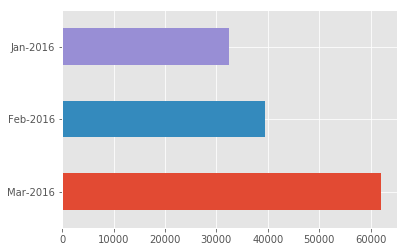

In [5]:
loan['issue_d'].value_counts().plot.barh()

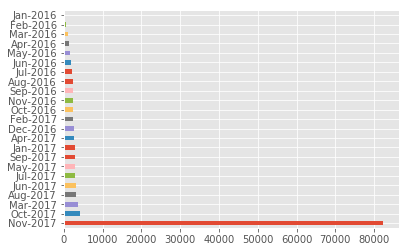

In [6]:
loan['last_pymnt_d'].value_counts().plot.barh()

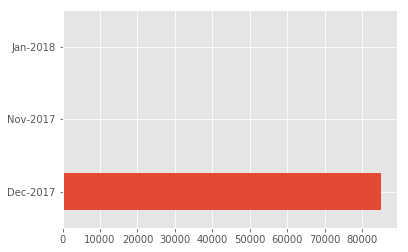

In [7]:
loan['next_pymnt_d'].value_counts().plot.barh()

In [8]:
loan.groupby(['loan_status', loan['next_pymnt_d'].isnull(), 
              loan['last_pymnt_d'].isnull()]).size()

loan_status         next_pymnt_d  last_pymnt_d
Charged Off         True          False           12895
                                  True              148
Current             False         False           79931
Default             False         False              11
Fully Paid          True          False           35650
In Grace Period     False         False            1637
Late (16-30 days)   False         False             458
Late (31-120 days)  False         False            3157
dtype: int64

If it is fully paid, the "next payment day" is nan.

If it is charged off, the "next payment day" is nan, the "last payment day" is nan or not nan.

## Data Cleaning & Feature Engineering

### Update features to reflect loan is jointly applied

In [9]:
loan['dti'] = np.where(loan['dti_joint'] > 0, loan['dti_joint'], loan['dti'])

loan['annual_inc'] = np.where(loan['annual_inc_joint'] > 0, 
                              loan['annual_inc_joint'], 
                              loan['annual_inc'])

loan['verification_status'] = np.where(loan['verification_status_joint'].notnull(), 
                                       loan['verification_status_joint'], 
                                       loan['verification_status'])

loan.drop(['dti_joint', 'annual_inc_joint', 'verification_status_joint'], axis=1, inplace=True)

print(loan['application_type'].unique())
loan.drop(['application_type'], axis=1,inplace=True)
loan.shape

['Individual' 'Joint App']


(133887, 147)

### Clean data - remove unnessary features

In [10]:
# Remove features with all NaN value
#loan.isnull().sum(axis=0)
sorted([(loan[loan.columns[i]].isnull().sum(), loan.columns[i]) for i in 
        range(len(loan.columns))], reverse=True)[:17]

[(133887, 'sec_app_revol_util'),
 (133887, 'sec_app_open_act_il'),
 (133887, 'sec_app_open_acc'),
 (133887, 'sec_app_num_rev_accts'),
 (133887, 'sec_app_mths_since_last_major_derog'),
 (133887, 'sec_app_mort_acc'),
 (133887, 'sec_app_inq_last_6mths'),
 (133887, 'sec_app_fico_range_low'),
 (133887, 'sec_app_fico_range_high'),
 (133887, 'sec_app_earliest_cr_line'),
 (133887, 'sec_app_collections_12_mths_ex_med'),
 (133887, 'sec_app_chargeoff_within_12_mths'),
 (133887, 'revol_bal_joint'),
 (133887, 'member_id'),
 (133877, 'desc'),
 (133252, 'orig_projected_additional_accrued_interest'),
 (133113, 'payment_plan_start_date')]

In [11]:
loan = loan.drop(['sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_open_acc',
                  'sec_app_num_rev_accts','sec_app_mths_since_last_major_derog',
                  'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_fico_range_low',
                  'sec_app_fico_range_high','sec_app_earliest_cr_line',
                  'sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med', 
                  'revol_bal_joint','member_id','desc'],axis=1)
loan.shape

(133887, 132)

In [12]:
# Remove features with same values, that is, len(feature.unique()==1).
colnames_uni_is_one = [(loan.columns[i]) for i in range(len(loan.columns)) 
 if len(loan[loan.columns[i]].unique())==1]

print(colnames_uni_is_one)
loan.drop(colnames_uni_is_one, axis=1, inplace=True)
loan.shape

['policy_code']


(133887, 131)

In [13]:
# Remove features with all different values, that is, len(feature.unique()==shape[1]).
[(loan.columns[i]) for i in range(len(loan.columns)) if 
 len(loan[loan.columns[i]].unique())==loan.shape[1]]

[]

### Process all dates related columns

In [14]:
colnames_date = ['issue_d','next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
                 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                 'debt_settlement_flag_date', 'settlement_date', 'earliest_cr_line']

for col in colnames_date:
    loan[col] = pd.to_datetime(loan[col])

loan[colnames_date].head(2)

,issue_d,next_pymnt_d,last_pymnt_d,last_credit_pull_d,hardship_start_date,hardship_end_date,payment_plan_start_date,debt_settlement_flag_date,settlement_date,earliest_cr_line
0,2016-03-01,NaT,2016-05-01,2016-11-01,NaT,NaT,NaT,NaT,NaT,2000-11-01
1,2016-03-01,2017-12-01,2017-11-01,2017-11-01,NaT,NaT,NaT,NaT,NaT,2006-08-01


#### change dates related features to months since the issue month

In [15]:
for col in colnames_date[1:]:
    loan[col + '_since_issue'] = loan[col].dt.to_period('M') - loan['issue_d'].dt.to_period('M')

In [16]:
loan = loan.drop(['next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
                 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                 'debt_settlement_flag_date', 'settlement_date', 'earliest_cr_line'], axis=1)

In [17]:
loan.groupby([loan['pymnt_plan'], 'loan_status']).size()

pymnt_plan  loan_status       
n           Charged Off           13043
            Current               79929
            Default                  11
            Fully Paid            35650
            In Grace Period        1635
            Late (16-30 days)       453
            Late (31-120 days)     2914
y           Current                   2
            In Grace Period           2
            Late (16-30 days)         5
            Late (31-120 days)      243
dtype: int64

### Dealing with missing value

In [ ]:
# sorted([(loan[loan.columns[i]].isnull().sum(), loan.columns[i]) 
#         for i in range(len(loan.columns))], reverse=True)

#### Results
Features related to the hardship progam:
 * (133252, 'orig_projected_additional_accrued_interest'),
 * (133113, 'payment_plan_start_date'),
 * (133113, 'hardship_type'),
 * (133113, 'hardship_status'),
 * (133113, 'hardship_start_date'),
 * (133113, 'hardship_reason'),
 * (133113, 'hardship_payoff_balance_amount'),
 * (133113, 'hardship_loan_status'),
 * (133113, 'hardship_length'),
 * (133113, 'hardship_last_payment_amount'),
 * (133113, 'hardship_end_date'),
 * (133113, 'hardship_dpd'),
 * (133113, 'hardship_amount'),
 * (133113, 'deferral_term')
 
Features related to settlement:
 * (132800, 'settlement_term'),
 * (132800, 'settlement_status'),
 * (132800, 'settlement_percentage'),
 * (132800, 'settlement_date'),
 * (132800, 'settlement_amount'),
 * (132800, 'debt_settlement_flag_date')
 
Others:
 * (110216, 'mths_since_last_record'),
 * (100131, 'mths_since_recent_bc_dlq'),
 * (95813, 'mths_since_last_major_derog'),
 * (86104, 'mths_since_recent_revol_delinq'),
 * (64565, 'mths_since_last_delinq'),
 * (48693, 'next_pymnt_d_since_issue'),
 * (17879, 'il_util'),
 * (13798, 'mths_since_recent_inq'),
 * (10621, 'title'),
 * (8981, 'emp_title'),
 * (8944, 'emp_length'),
 * (7621, 'num_tl_120dpd_2m'),
 * (3701, 'mths_since_rcnt_il'),
 * (3646, 'mo_sin_old_il_acct'),
 * (1175, 'bc_util'),
 * (1129, 'percent_bc_gt_75'),
 * (1111, 'bc_open_to_buy'),
 * (1044, 'mths_since_recent_bc'),
 * (148, 'last_pymnt_d_since_issue'),
 * (71, 'revol_util'),
 * (67, 'all_util'),
 * (62, 'total_cu_tl'),
 * (62, 'open_acc_6m'),
 * (62, 'inq_last_12m'),
 * (61, 'total_bal_il'),
 * (61, 'open_rv_24m'),
 * (61, 'open_rv_12m'),
 * (61, 'open_il_24m'),
 * (61, 'open_il_12m'),
 * (61, 'open_act_il'),
 * (61, 'max_bal_bc'),
 * (61, 'inq_fi'),
 * (2, 'last_credit_pull_d_since_issue'),
 * (1, 'inq_last_6mths'),

#### Remove features about the hardship program and settlement, since these records are past due, they cannot be used to classify whether a record would past due or not.
#### Also remove features with lots of missing value to make my job easier.

In [18]:
# remove features about the hardship program and settlement, since these records are past due, 
# they cannot be used to classify whether a record would past due or not
# also remove features with lots of missing value to make my job easier

loan = loan.drop(['orig_projected_additional_accrued_interest',
                  'hardship_type','hardship_status','hardship_reason',
                  'hardship_payoff_balance_amount','hardship_loan_status','hardship_length',
                  'hardship_last_payment_amount','hardship_dpd',
                  'hardship_amount','deferral_term', # hardship program
                  'settlement_term','settlement_status','settlement_percentage',
                  'settlement_amount', # settlement
                  'mths_since_last_record','mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog','mths_since_recent_revol_delinq',
                  'mths_since_last_delinq', # missing > 60,000
                  'payment_plan_start_date_since_issue','hardship_start_date_since_issue',
                  'hardship_end_date_since_issue','settlement_date_since_issue',
                  'debt_settlement_flag_date_since_issue','emp_title','emp_length',
                  'il_util','mths_since_recent_inq','num_tl_120dpd_2m',
                  'mths_since_rcnt_il','mo_sin_old_il_acct','bc_util','percent_bc_gt_75',
                  'bc_open_to_buy','mths_since_recent_bc'# missing > 1,000
                 ], axis=1)
loan.shape

(133887, 95)

### Fill missing values

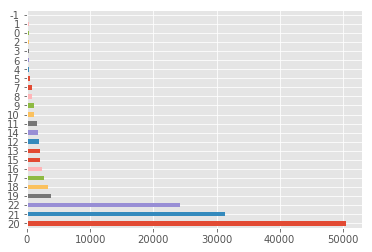

In [19]:
loan['last_credit_pull_d_since_issue'].value_counts().plot.barh()
loan['last_credit_pull_d_since_issue'].fillna(-1, inplace=True)

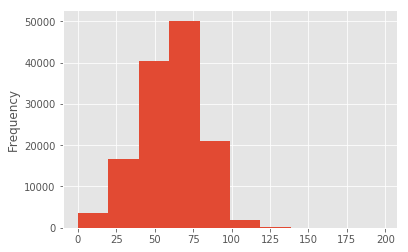

In [20]:
loan['all_util'].plot.hist()
loan['all_util'].fillna(loan['all_util'].median(), inplace=True)

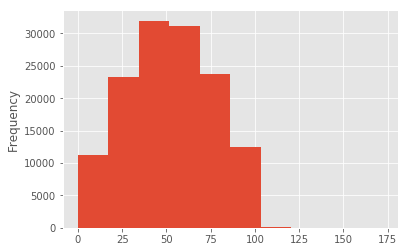

In [21]:
loan['revol_util'] = loan['revol_util'].str.replace('%','').astype(float)
loan['revol_util'].plot.hist()
loan['revol_util'].fillna(loan['revol_util'].median(), inplace=True)

In [22]:
print(loan['total_bal_il'].describe())
loan['total_bal_il'].fillna(loan['total_bal_il'].median(), inplace=True)

count    133826.000000
mean      35704.147819
std       42167.837355
min           0.000000
25%        9633.250000
50%       24144.000000
75%       46561.750000
max      796104.000000
Name: total_bal_il, dtype: float64


In [23]:
print(loan['max_bal_bc'].describe())
loan['max_bal_bc'].fillna(loan['max_bal_bc'].median(), inplace=True)

count    133826.000000
mean       6183.582271
std        6214.568114
min           0.000000
25%        2525.000000
50%        4664.000000
75%        8020.000000
max      776843.000000
Name: max_bal_bc, dtype: float64


In [24]:
loan['total_cu_tl'].fillna(0, inplace=True)
loan['open_acc_6m'].fillna(0, inplace=True)
loan['open_rv_24m'].fillna(0, inplace=True)
loan['open_rv_12m'].fillna(0, inplace=True)
loan['open_il_24m'].fillna(0, inplace=True)
loan['open_il_12m'].fillna(0, inplace=True)
loan['open_act_il'].fillna(0, inplace=True)
loan['inq_last_6mths'].fillna(0, inplace=True)
loan['inq_last_12m'].fillna(0, inplace=True)
loan['inq_fi'].fillna(0, inplace=True)

loan['title'].fillna('Other', inplace=True)
loan['next_pymnt_d_since_issue'].fillna(-1, inplace=True)
loan['last_pymnt_d_since_issue'].fillna(-1, inplace=True)

In [25]:
loan.shape

(133887, 95)

### Select numerical and categorical features

In [26]:
loan.drop(['id'], axis=1, inplace=True)

In [27]:
## numeric variables
loan['int_rate'] = loan['int_rate'].str.replace('%','').astype(float)
cols_numeric = list( (loan.describe()).columns)
print(len(cols_numeric))

for col in cols_numeric:
    loan[col] = loan[col].astype(float) 

76


### create the binary target

In [28]:
# okay: 0    past due: 1
loan['loan_status_binary'] = np.where(loan['loan_status']==('Current'or'Fully Paid'), 0, 1)
loan['loan_status_binary'].value_counts()

0    79931
1    53956
Name: loan_status_binary, dtype: int64

### use t test to select numerical variables

In [29]:
from scipy import stats

for col in cols_numeric:
    t_stat, p_value = stats.ttest_ind(loan[col],loan['loan_status_binary'], equal_var = False)
    # print(t_stat, p_value)
    if p_value > 0.05:
        cols_numeric.remove(col)
    
len(cols_numeric)

76

The t test does not help us to reduce the number of numerical features. Need to do that manually later.

#### Categorical features

In [30]:
cols_categorical = list(set(loan.columns) - set(cols_numeric))
cols_categorical

['disbursement_method',
 'earliest_cr_line_since_issue',
 'url',
 'home_ownership',
 'term',
 'zip_code',
 'debt_settlement_flag',
 'hardship_flag',
 'sub_grade',
 'initial_list_status',
 'pymnt_plan',
 'grade',
 'title',
 'verification_status',
 'issue_d',
 'purpose',
 'loan_status_binary',
 'loan_status',
 'addr_state']

In [31]:
loan.drop(['loan_status','grade','sub_grade','hardship_flag','debt_settlement_flag',
           'initial_list_status','earliest_cr_line_since_issue',
           'url','addr_state','issue_d'], axis=1, inplace=True)

In [32]:
cols_categorical = list(set(loan.columns) - set(cols_numeric))
cols_categorical

['disbursement_method',
 'home_ownership',
 'term',
 'loan_status_binary',
 'zip_code',
 'title',
 'verification_status',
 'purpose',
 'pymnt_plan']

#### collapse the feature zipcode by calculation

In [33]:
zip_bi_status = loan.groupby(['zip_code', loan['loan_status_binary']]).size().unstack()
zip_bi_status.head(2)

loan_status_binary,0,1
zip_code,,
007xx,NaN,1.0
008xx,2.0,NaN


In [34]:
zip_bi_status = zip_bi_status.reset_index()
zip_pd_rate = zip_bi_status[1]/zip_bi_status[0]
zip_pd_rate.fillna(0, axis=0, inplace=True)
zip_pd_rate.describe()

count    891.000000
mean       0.669338
std        0.305896
min        0.000000
25%        0.543031
50%        0.653846
75%        0.760384
max        4.000000
dtype: float64

In [35]:
zip_bi_status['new_zip'] = pd.qcut(zip_pd_rate, 10)
zip_bi_status['new_zip'].value_counts()

(0.654, 0.692]     91
(0.61, 0.654]      90
(0.405, 0.519]     90
(-0.001, 0.405]    90
(0.918, 4.0]       89
(0.805, 0.918]     89
(0.742, 0.805]     89
(0.563, 0.61]      89
(0.519, 0.563]     88
(0.692, 0.742]     86
Name: new_zip, dtype: int64

In [36]:
zip_bi_status.drop([0,1], axis=1, inplace=True)
zip_bi_status.head()

loan_status_binary,zip_code,new_zip
0,007xx,"(-0.001, 0.405]"
1,008xx,"(-0.001, 0.405]"
2,009xx,"(-0.001, 0.405]"
3,010xx,"(0.563, 0.61]"
4,011xx,"(0.805, 0.918]"


In [37]:
loan = pd.merge(loan, zip_bi_status, how='left', on = 'zip_code')
loan.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,annual_inc,verification_status,pymnt_plan,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,next_pymnt_d_since_issue,last_pymnt_d_since_issue,last_credit_pull_d_since_issue,loan_status_binary,new_zip
0,16000.0,16000.0,16000.0,36 months,5.32,481.84,RENT,105000.0,Not Verified,n,...,47543.0,23525.0,19400.0,25243.0,Cash,-1.0,2.0,8.0,1,"(0.654, 0.692]"
1,17000.0,17000.0,17000.0,36 months,9.75,546.55,MORTGAGE,40000.0,Verified,n,...,44131.0,31939.0,16300.0,27831.0,Cash,21.0,20.0,20.0,0,"(0.563, 0.61]"


In [39]:
loan.drop(['zip_code'], axis=1, inplace=True)
loan.shape

(133887, 85)

In [40]:
loan.to_csv('LoanStats_2016Q1_cleaned.csv', index=False)

### Start build model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

loan =  pd.read_csv('LoanStats_2016Q1_cleaned.csv')
loan.shape

(133887, 85)

#### Numerical features
* 'int_rate', 'installment', 'annual_inc', 'dti', 'last_pymnt_amnt', 'total_bal_il', 'revol_util', 

* 'loan_amnt', ('funded_amnt', 'funded_amnt_inv',) 

* 'total_pymnt', ('total_pymnt_inv',) 

* 'out_prncp', ('out_prncp_inv',)

* 'fico_range_low',('fico_range_high',)

* 'last_fico_range_low', ('last_fico_range_high',)

* 'inq_last_6mths', 'inq_last_12m', 

* 'open_il_12m', ('open_il_24m',) 

* 'open_rv_12m', ('open_rv_24m',) 
 
* ('total_acc',) 'open_acc','open_acc_6m', 'acc_open_past_24mths', 'open_act_il', 

* 'num_actv_bc_tl', ('num_actv_rev_tl', 'num_bc_sats',)

* 'num_bc_tl', ('num_rev_accts',)

* 'delinq_2yrs', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt','tot_cur_bal', 'avg_cur_bal', 'revol_bal', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',  'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'num_il_tl', 'num_op_rev_tl',  'num_rev_tl_bal_gt_0', 'num_sats', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit', 'total_bal_ex_mort', 'next_pymnt_d_since_issue', 'last_pymnt_d_since_issue', 'last_credit_pull_d_since_issue', 

#### check the correlation and drop some features

In [55]:
cols = ['num_actv_rev_tl', 'num_bc_sats',]
np.corrcoef(loan[cols].values.T)

array([[ 1.        ,  0.68822838],
       [ 0.68822838,  1.        ]])

In [56]:
loan.drop(['funded_amnt', 'funded_amnt_inv', 'total_pymnt_inv', 'out_prncp_inv',
           'fico_range_high', 'last_fico_range_high', 'open_il_24m', 'open_rv_24m',
           'total_acc', 'num_actv_rev_tl', 'num_bc_sats', 'num_rev_accts'
          ], axis=1, inplace=True)

In [70]:
# from pandas.plotting import scatter_matrix
# cols = ['int_rate', 'installment', 'annual_inc', 'dti']
# scatter_matrix(loan[cols], figsize=(12,12))

In [ ]:
# np.log(loan['loan_amnt']).describe()
# np.log(loan['revol_bal']+1).describe()
# np.log(loan['out_prncp']+1).plot.hist()

## transform some features
loan['log_loan_amnt'] = np.log(loan['loan_amnt'])
loan['log_revol_bal'] = np.log(loan['revol_bal']+1)

#### Categorical features

In [57]:
cols_categorical = ['disbursement_method','home_ownership','term','loan_status_binary',
                    'new_zip','title','verification_status', 'purpose','pymnt_plan']

#### onehot encoding

In [58]:
X = loan

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [60]:
# need do label encoding for string features to int before onehot encoding
le = LabelEncoder()
for col in cols_categorical:
    le.fit(X[col])
    X[col] = le.transform(X[col])

In [61]:
X[cols_categorical].head(3)

,disbursement_method,home_ownership,term,loan_status_binary,new_zip,title,verification_status,purpose,pymnt_plan
0,0,2,0,1,5,4,0,2,0
1,0,0,0,0,3,3,2,1,0
2,0,0,1,1,6,7,1,3,0


In [62]:
enc = OneHotEncoder()
enc.fit(X[cols_categorical])  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [63]:
X_cate = enc.transform(X[cols_categorical])
enc.n_values_, enc.feature_indices_

(array([ 2,  3,  2,  2, 10, 13,  3, 12,  2]),
 array([ 0,  2,  5,  7,  9, 19, 32, 35, 47, 49]))

In [65]:
X_num = X.drop(cols_categorical, axis=1).values
X_num.shape, X_cate.shape

((133887, 64), (133887, 49))

In [116]:
from scipy.sparse import hstack
X_new = hstack((X_cate, X_num))
X_new.shape

(133887, 113)

#### split data into training and test datasets

In [117]:
from sklearn.model_selection import train_test_split

y = X['loan_status_binary']
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

### Build a Logistic Regression Classifier

In [140]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(C=0.01, penalty='l1')
logis.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
logis.score(X_train, y_train), logis.score(X_test, y_test)

(1.0, 1.0)

In [136]:
logis.coef_, len(logis.coef_[0])

(array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,  -2.24840906e+00,   7.31260365e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.000000

Text(0,0.5,'Coefficients')

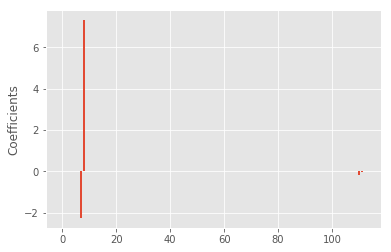

In [137]:
#range = np.arange(73) + 1
#pca_names = ['PCA_%s' % i for i in pca_range]
plt.bar(np.arange(113), logis.coef_.flatten())
#xticks = plt.xticks(pca_range, pca_names, rotation=90)
plt.ylabel('Coefficients')

### Build a Random Forest Classifier

In [123]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,
                                   max_depth=40,
                                   min_samples_leaf=3, 
                                   min_samples_split=5,
                                   random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [124]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(1.0, 1.0)

In [125]:
rfc.feature_importances_, len(rfc.feature_importances_)

(array([  9.57612730e-07,   1.02177495e-06,   1.43691904e-05,
          7.69202286e-06,   9.62733631e-06,   3.89946862e-05,
          1.25853710e-04,   1.83997502e-01,   2.50213109e-01,
          4.29768201e-07,   5.34403596e-06,   6.07452133e-06,
          7.29830949e-06,   8.61182870e-06,   7.94218288e-06,
          8.50175143e-06,   9.79443131e-06,   1.23387589e-05,
          3.74345779e-06,   7.81661740e-07,   4.01048617e-06,
          0.00000000e+00,   4.89078520e-06,   1.11713266e-05,
          0.00000000e+00,   1.88347325e-06,   3.97857818e-06,
          2.44423292e-06,   1.36482031e-06,   2.31702206e-06,
          6.01139116e-06,   2.54405024e-06,   1.45472859e-04,
          8.31391135e-06,   5.47868993e-05,   7.73417271e-08,
          1.45645259e-05,   1.88902973e-05,   1.54690161e-06,
          1.78563090e-06,   3.01182931e-06,   1.13703898e-06,
          0.00000000e+00,   2.71539561e-06,   0.00000000e+00,
          2.13024577e-06,   2.70893293e-06,   6.94117528e-04,
        

Text(0,0.5,'Coefficients')

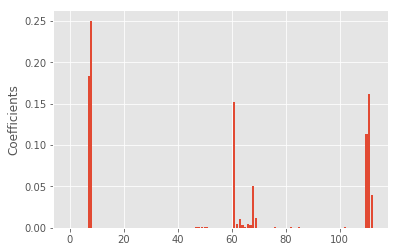

In [129]:
plt.bar(np.arange(113), rfc.feature_importances_.flatten())
#xticks = plt.xticks(pca_range, pca_names, rotation=90)
plt.ylabel('Coefficients')